<a href="https://colab.research.google.com/github/christievanderuit/TM10007_group11/blob/main/TM10007_Group11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Test

Hoi ik heb dit deel aangepast nadat ik hem denk ik heb afgesplitst in een eigen branch?
nu weer proberen te mergen met main branch

In [1]:
!pip install sklearn numpy matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any.whl size=2955 sha256=261ee80ab229c7e5bb5ab70e4d1680dd01c4c818fa10161b28ccdd89a8272de5
  Stored in directory: /root/.cache/pip/wheels/f8/e0/3d/9d0c2020c44a519b9f02ab4fa6d2a4a996c98d79ab2f569fa1
Successfully built sklearn


In [2]:
# General packages
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets as ds
import seaborn


# Classifiers
from sklearn import model_selection
from sklearn import metrics
from sklearn import feature_selection 
from sklearn import preprocessing
from sklearn import neighbors
from sklearn import svm

hoi hoi


In [3]:
# Some functions we will use
def colorplot(clf, ax, x, y, h=100):
    '''
    Overlay the decision areas as colors in an axes.
    
    Input:
        clf: trained classifier
        ax: axis to overlay color mesh on
        x: feature on x-axis
        y: feature on y-axis
        h(optional): steps in the mesh
    '''
    # Create a meshgrid the size of the axis
    xstep = (x.max() - x.min() ) / 20.0
    ystep = (y.max() - y.min() ) / 20.0
    x_min, x_max = x.min() - xstep, x.max() + xstep
    y_min, y_max = y.min() - ystep, y.max() + ystep
    h = max((x_max - x_min, y_max - y_min))/h
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    if hasattr(clf, "decision_function"):
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    else:
        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])
    if len(Z.shape) > 1:
        Z = Z[:, 1]
    
    # Put the result into a color plot
    cm = plt.cm.RdBu_r
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)
    del xx, yy, x_min, x_max, y_min, y_max, Z, cm

In [4]:
# Run this to use from colab environment
!git clone https://github.com/jveenland/tm10007_ml.git
import os
import pandas as pd
data = pd.read_csv('/content/tm10007_ml/worcgist/GIST_radiomicFeatures.csv', index_col=0)
print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')

Cloning into 'tm10007_ml'...
remote: Enumerating objects: 83, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 83 (delta 13), reused 12 (delta 12), pack-reused 62
Unpacking objects: 100% (83/83), 67.93 MiB | 12.81 MiB/s, done.
The number of samples: 246
The number of columns: 494


In [ ]:
#zorgen dat verschillende functies uit de files aangeroepen kunnen worden 
from tm10007_ml.worcgist.load_data import *   #misschien dat dit nog op een nettere manier kan 
dataset = load_data(); 

In [5]:
#Splitsen in een train en in een testset 

# Classifiers
from sklearn.model_selection import train_test_split

#Waarbij x = features, y = label
#vraag: doet ie dit elke keer op een andere manier? want dan toch lastig conclusies te trekken? --> daarom achter random state een getal - maakt niet uit zolang integer is
y = data['label']
x = data.drop("label", axis='columns')
# df_train, df_test = train_test_split(data, test_size=0.2, random_state=1)
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2, random_state=1, stratify=y)
#AFBLIJVEN VAN TESTDATA!! :) 





In [19]:
#Testen of de data normaal verdeeld is of niet 
from scipy.stats import shapiro
  
# define a function to test for normality using the Shapiro-Wilk test
def test_normality(column):
    stat, p = shapiro(column)
    alpha = 0.05
    if p > alpha:
        return 1
    else:
        return 0

# apply the test_normality function to each column of the DataFrame
normality_results = x_train.apply(test_normality)

# print the results
print(normality_results)
# sum = sum(normality_results)
print(sum)

#dus meeste data is niet normaal verdeeld voor 60 van de gevallen --> dus voor deze wil je 
#een andere schaling gaan toepassen 

# losse dataframes maken 
normalized = pd.DataFrame()
non_normalized = pd.DataFrame()
for ind, elem in zip(x_train.columns, normality_results): 
  if elem == 0: 
    non_normalized = non_normalized.append(x_train[ind])
  else: 
    normalized = normalized.append(x_train[ind])
  

#los scalen 
scaler = preprocessing.RobustScaler()
scaler.fit(non_normalized)
non_normalized = pd.DataFrame(scaler.transform(non_normalized))

scaler_norm = preprocessing.StandardScaler()
scaler_norm.fit(normalized)
normalized = pd.DataFrame(scaler_norm.transform(normalized))

#non_normalized en normalized gecombineerd in een nieuwe dataframe
x_train_scaled = pd.concat([non_normalized, normalized])
scaler_tot = preprocessing.MinMaxScaler()
scaler_tot.fit(x_train_scaled)
x_train_scaled = pd.DataFrame(scaler_tot.transform(x_train_scaled))

#x_train_scaled = normalized.append(non_normalized)
# 1. losse df voor normalized en non normalized 
# 2. scaling met Robust en Standard 
# 3. Samenvoegen en alles met Min max normalizeren 


PREDICT_original_sf_compactness_avg_2.5D                  0
PREDICT_original_sf_compactness_std_2.5D                  0
PREDICT_original_sf_rad_dist_avg_2.5D                     0
PREDICT_original_sf_rad_dist_std_2.5D                     0
PREDICT_original_sf_roughness_avg_2.5D                    0
                                                         ..
PREDICT_original_phasef_phasesym_peak_position_WL3_N5     1
PREDICT_original_phasef_phasesym_range_WL3_N5             0
PREDICT_original_phasef_phasesym_energy_WL3_N5            0
PREDICT_original_phasef_phasesym_quartile_range_WL3_N5    0
PREDICT_original_phasef_phasesym_entropy_WL3_N5           1
Length: 493, dtype: int64
<built-in function sum>
              0             1             2             3             4    \
0    3.055518e-08  4.684812e-08  4.457935e-09  2.482722e-10  2.178581e-07   
1    3.054830e-08  4.669807e-08  4.441734e-09  2.476093e-10  2.169444e-07   
2    3.414806e-08  5.203303e-08  5.598507e-09  3.260287e-10

/usr/local/lib/python3.9/dist-packages/scipy/stats/_morestats.py:1813: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
<ipython-input-19-08caba18a98d>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  non_normalized = non_normalized.append(x_train[ind])
<ipython-input-19-08caba18a98d>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  non_normalized = non_normalized.append(x_train[ind])
<ipython-input-19-08caba18a98d>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  non_normalized = non_normalized.append(x_train[ind])
<ipython-input-19-08caba18a98d>:29: FutureWarning: The frame.append method is deprecated and will be r

In [ ]:
print(non_normalized)

[ID
GIST-083_0    0.371705
GIST-133_0    0.796716
GIST-145_0    0.826348
GIST-001_0    0.797427
GIST-139_0    0.894811
                ...   
GIST-185_0    0.814293
GIST-032_0    0.868296
GIST-080_0    0.689300
GIST-089_0    0.859021
GIST-211_0    0.562105
Name: PREDICT_original_sf_compactness_avg_2.5D, Length: 196, dtype: float64, ID
GIST-083_0    0.316183
GIST-133_0    0.118745
GIST-145_0    0.065400
GIST-001_0    0.120594
GIST-139_0    0.049648
                ...   
GIST-185_0    0.063864
GIST-032_0    0.037218
GIST-080_0    0.167670
GIST-089_0    0.060170
GIST-211_0    0.209889
Name: PREDICT_original_sf_compactness_std_2.5D, Length: 196, dtype: float64, ID
GIST-083_0    29.371701
GIST-133_0    24.223771
GIST-145_0    54.400641
GIST-001_0    80.192445
GIST-139_0    14.791211
                ...    
GIST-185_0    31.262951
GIST-032_0    15.420416
GIST-080_0    91.820259
GIST-089_0    13.297123
GIST-211_0    30.444289
Name: PREDICT_original_sf_rad_dist_avg_2.5D, Length: 196, dtype: f

<class 'pandas.core.series.Series'>


TypeError: ignored

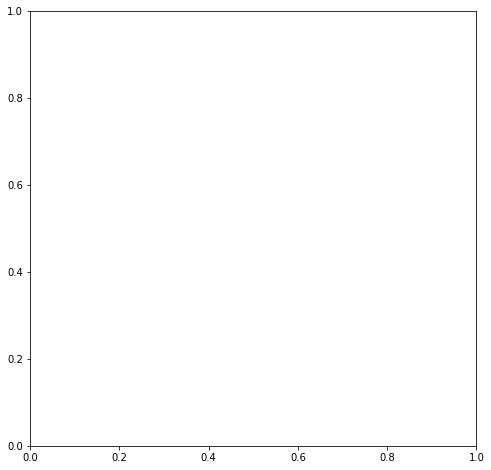

In [ ]:
#plotten 

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1)
print(type(x_train['PREDICT_original_hf_min']))
plt.scatter(x_train['PREDICT_original_phasef_phasesym_peak_position_WL3_N5'], x_train['PREDICT_original_phasef_phasesym_range_WL3_N5'])
# plt.show()
